# Events Table Stratified

__Description__: 
A Stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data (or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max. potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for statified sampling; maximum return interval limit for the statified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the curves.


#### Import Libraries

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*

In [2]:
## Excess rainfall parameters:
CN  = 73       # Curve number
mu  = 0.2  #Intial abstraction ratio parameter
PMP = 20   #inches, Probable Maximum Precipitation for the selected duration 

Return_Intervals = np.array([ 2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000]) #Return Intervals evaluated
RI_upper_bound = 3700 #Upper Limit of recurrence interval evaluation, Suggest not changing this value
Aerial_Reduction = 1.0 #Aerial Reduction Factor

duration = 24   # Event duration in hour #Must be a duration in the input Precip_Table File

#Integration parameters
n_partition = 30 #Define number of partitions of max. potential retention distribution.
                 #This controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'DesPlaines'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN =         '071200040403'   # Domain/boundary condition name

#NOAA Data
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN) 
#Mean Precip Curve Data
precip_mean_curve_table = '{0}_{1}_{2}_MeanCurve.csv'.format(Project_Area, Pluvial_Model, BCN) 

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_plots = True
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Excess rainfall parameters:
lower_limit, upper_limit = 1, 3000 

## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### NOAA Atlas 14 Precipitation Values

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.379714,2.117918,2.702459
2,2.891592,2.574480,3.286755
5,3.701163,3.283337,4.207439
10,4.377602,3.863020,4.969184
25,5.377439,4.696378,6.100418
50,6.235949,5.403653,7.084265
100,7.189133,6.155010,8.170133
200,8.249031,6.967184,9.403857
500,9.851490,8.155633,11.288959


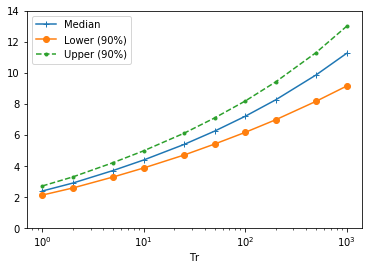

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)

raw_precip.rename(columns = {'Expected Value':'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, 14))

raw_precip

### Fit GEV to Rainfal Data (Find GEV parameters)

In [6]:
#reduce precip by aerial reduction factor
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns] * Aerial_Reduction

#Find GEV parameters for the median curve
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
GEV_parameters_M =df_GEV_parameters_M.to_numpy().transpose()[0]

#Find GEV parameters for the upper curve of the 90% confidence interval
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
GEV_parameters_U =df_GEV_parameters_U.to_numpy().transpose()[0]

#Find GEV parameters for the lower curve of the 90% confidence interval
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
GEV_parameters_L =df_GEV_parameters_L.to_numpy().transpose()[0]

dfs = [df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U]
df_GEV_parameters = pd.concat(dfs, axis=1)
df_GEV_parameters 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04256935345698326
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.032377611868098656
            Iterations: 19
            Function evaluations: 106
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.056679706305320314
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13


,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.755150,2.446070,3.139833
sigma,0.574647,0.532820,0.627433
xi,-0.204410,-0.163136,-0.222317


### Plot Fitted GEV Distribution and NOAA Data

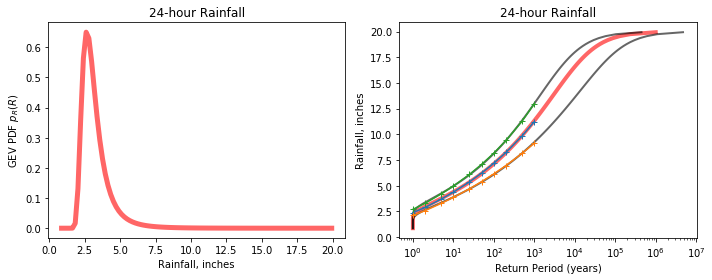

In [7]:
# Define figure including figure dimensions
fig, ((fig1a, fig1b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#fig, ax = plt.subplots(1, 1)

Precip = np.linspace(PPF_GEV(10**-100, GEV_parameters_M, PMP),PPF_GEV(.999999, GEV_parameters_M, PMP), 100)

Return_Period_Precip_E=1/(1-CDF_GEV(Precip, GEV_parameters_M, PMP))
Return_Period_Precip_L=1/(1-CDF_GEV(Precip, GEV_parameters_L, PMP))
Return_Period_Precip_U=1/(1-CDF_GEV(Precip, GEV_parameters_U, PMP))

#Create First Panel Figure
fig1a.plot(Precip, PDF_GEV(Precip, GEV_parameters_M, PMP) ,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
fig1a.set_xlabel('Rainfall, inches'),fig1a.set_ylabel('GEV PDF $p_R(R)$'), fig1a.set_title('24-hour Rainfall')

#Create Second Panel Figure

fig1b.set_xscale('log')
fig1b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=4, alpha=0.6, label='genextreme pdf')
fig1b.plot(Return_Period_Precip_L, Precip,
    'k-', lw=2, alpha=0.6, label='genextreme pdf')
fig1b.plot(Return_Period_Precip_U, Precip,
    'k-', lw=2, alpha=0.6, label='genextreme pdf')
raw_precip_reduced['Median'].plot(style=['+-','o-','.--','s:'],logx=True)
raw_precip_reduced['Lower (90%)'].plot(style=['+-','o-','.--','s:'],logx=True )
raw_precip_reduced['Upper (90%)'].plot(style=['+-','o-','.--','s:'],logx=True)
fig1b.set_xlabel('Return Period (years)'),fig1b.set_ylabel('Rainfall, inches'), fig1b.set_title('24-hour Rainfall')

plt.tight_layout()
plt.show()

### Data for Calculating the Mean Curve

In [8]:
#Additional Return Intervals evaluated for the mean curve
Return_Intervals_MC =  np.array([ 1.01, 1.05, 1.11, 1.25, 20,\
                                 2000, 5000, 10000, 20000,\
                                 50000., 100000., 200000., 1/2E-06,\
                                1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07 ]) 

Mean_Curve_data = Mean_Curve_RI_data(raw_precip_reduced, Return_Intervals_MC, df_GEV_parameters, PMP)
Mean_Curve_data 

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.379714,2.117918,2.702459,0.070849,0.077314,0.077314,0.866980
1.01,2.000418,1.724906,2.326368,0.090081,0.091764,0.091764,0.693356
1.05,2.182937,1.903610,2.520997,0.083234,0.087528,0.087528,0.780671
1.11,2.312590,2.028762,2.660104,0.079600,0.085105,0.085105,0.838368
1.25,2.494542,2.202098,2.856443,0.075802,0.082354,0.082354,0.914105
2.00,2.891592,2.574480,3.286755,0.070614,0.077868,0.077868,1.061807
5.00,3.701163,3.283337,4.207439,0.072819,0.077937,0.077937,1.308647
10.00,4.377602,3.863020,4.969184,0.076019,0.077054,0.077054,1.476501
20.00,5.101648,4.482087,5.776025,0.078708,0.075472,0.078708,1.629564
25.00,5.377439,4.696378,6.100418,0.082323,0.076684,0.082323,1.682212


### Input for Calculating the Mean Curve

In [9]:
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, .99, 0.995, 0.999])

mu_LN =Mean_Curve_data['mu LN'].to_numpy()
SD = Mean_Curve_data['Max Log SD'].to_numpy()

data= [[stats.lognorm.ppf(CL1/Norm_Constant_LN(SD1, mu1, PMP), SD1, scale = np.exp(mu1) )  for CL1 in CL ] for mu1, SD1 in zip(mu_LN, SD) ]

df_input = pd.DataFrame(data=data, columns = CL, index =  1/Mean_Curve_data.index.to_numpy()).sort_index(axis=0 ,ascending=True)

df_input.index.name ='AEP'

df_input = df_input.drop([1]) # drop last n rows#Drop the last row with the one year value

df_input.to_csv(outputs_dir/'Mean_Curve_Input_{0}_{1}_{2}.csv'.format(Project_Area, Pluvial_Model, BCN))
df_input

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,19.970397,19.975902,19.978447,19.984881,19.987934,19.991209,19.993246,19.994756,19.995968,19.996987,19.997870,19.998653,19.999358,19.999686,19.999938,19.999969,19.999994
2.000000e-07,19.925614,19.937968,19.943796,19.958977,19.966486,19.974844,19.980253,19.984390,19.987806,19.990756,19.993378,19.995758,19.997953,19.998993,19.999801,19.999901,19.999980
5.000000e-07,19.815981,19.846343,19.860686,19.898109,19.916662,19.937350,19.950766,19.961044,19.969543,19.976893,19.983435,19.989382,19.994871,19.997476,19.999501,19.999751,19.999950
1.000000e-06,19.638489,19.697529,19.725475,19.798586,19.834955,19.875633,19.902093,19.922416,19.939263,19.953861,19.966886,19.978749,19.989723,19.994939,19.998999,19.999500,19.999900
2.000000e-06,19.302906,19.414663,19.467749,19.607301,19.677146,19.755684,19.807056,19.846695,19.879692,19.908400,19.934113,19.957626,19.979466,19.989877,19.997997,19.999000,19.999800
5.000000e-06,18.421710,18.662069,18.777294,19.084023,19.240035,19.418002,19.536205,19.628593,19.706430,19.774946,19.837038,19.894500,19.948534,19.974544,19.994949,19.997477,19.999496
1.000000e-05,17.268592,17.656181,17.844101,18.352226,18.615977,18.922486,19.130225,19.295491,19.437109,19.563917,19.680886,19.791174,19.896987,19.948752,19.989784,19.994894,19.998979
2.000000e-05,15.668222,16.219407,16.490578,17.239018,17.638138,18.113977,18.445937,18.717095,18.955717,19.175479,19.384520,19.588543,19.792215,19.895304,19.978902,19.989440,19.997886
5.000000e-05,13.218629,13.923363,14.276857,15.279810,15.834640,16.520530,17.019997,17.445423,17.837154,18.217207,18.602163,19.009030,19.461082,19.715670,19.940177,19.969881,19.993942


## Hydrology 2

,Expected Value,Median
Tr,,
1.111111,2.372917,2.314617
2.000000,2.954968,2.891592
5.000000,3.765830,3.701163
10.000000,4.437855,4.377602
20.000000,5.184909,5.101648
50.000000,6.332596,6.235949
100.000000,7.317501,7.189133
200.000000,8.429844,8.249031
500.000000,10.132771,9.851490


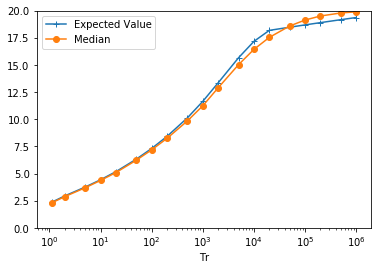

In [10]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir,index_col=0)

mean_curve_precip['Tr'] = 1/mean_curve_precip.index.to_numpy()
mean_curve_precip=mean_curve_precip.set_index('Tr')

mean_curve_precip.rename(columns = {'Q_Mean_cfs':'Expected Value', 'Q_Median_cfs':'Median'}, inplace = True)
mean_curve_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, PMP))

mean_curve_precip

### Fit GEV to Mean Precipication Curve (Find GEV parameters)

In [11]:
#Find GEV parameters for the median curve
fit_values_mean_curve_precip = mean_curve_precip[1:20000] #Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'Expected Value', PMP)
GEV_parameters_E = df_GEV_parameters_E.to_numpy().transpose()[0]
df_GEV_parameters_E

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.012679299734755534
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12


,GEV Expected Value
mu,2.738182
sigma,0.584266
xi,-0.213904


### Plot Fitted GEV Distribution and Mean Precipitation Curve

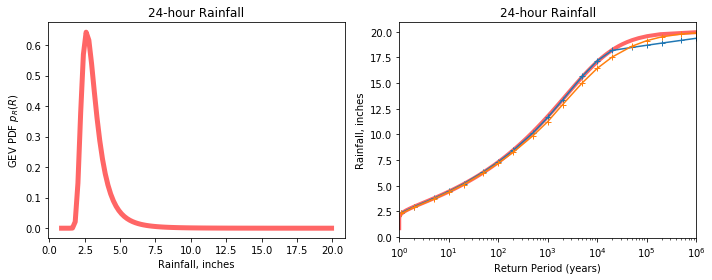

In [12]:
# Define figure including figure dimensions
fig, ((fig1a, fig1b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#fig, ax = plt.subplots(1, 1)

Precip = np.linspace(PPF_GEV(10**-100, GEV_parameters_E, PMP), PPF_GEV(.999999, GEV_parameters_E, PMP), 100)
Return_Period_Precip_E=1/(1-CDF_GEV(Precip, GEV_parameters_E, PMP))

#Create First Panel Figure
fig1a.plot(Precip, PDF_GEV(Precip, GEV_parameters_E, PMP) ,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
fig1a.set_xlabel('Rainfall, inches'),fig1a.set_ylabel('GEV PDF $p_R(R)$'), fig1a.set_title('24-hour Rainfall')

#Create Second Panel Figure

fig1b.set_xscale('log')
fig1b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=4, alpha=0.6, label='genextreme pdf')
fig1b.set_xlim(1, 10**6)
mean_curve_precip['Expected Value'].plot(style=['+-','o-','.--','s:'],logx=True)
mean_curve_precip['Median'].plot(style=['+-','o-','.--','s:'], logx=True)

fig1b.set_xlabel('Return Period (years)'),fig1b.set_ylabel('Rainfall, inches'), fig1b.set_title('24-hour Rainfall')

plt.tight_layout()
plt.show()

### Hydrology 2 Events

In [13]:
#Here add in script that processes the mean curve data points that are equivalent in RI to the original NOAA data points

#Return Intervals where precipitation already is calculated for the mean precip. curve.
RI_data = np.array([ 2, 5, 10, 50, 100, 200, 500, 1000, 2000])

df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'Expected Value', RI_data , CN, mu)
df_weights_rainfall

Bin Ceiling = 3700.0, Bin Average = 3000, Bin Floor = 2498.2392789933565
Bin Ceiling = 2498.2392789933565, Bin Average = 2000, Bin Floor = 1647.0614106025514
Bin Ceiling = 1647.0614106025514, Bin Average = 1000, Bin Floor = 684.5560578814546
Bin Ceiling = 684.5560578814546, Bin Average = 500, Bin Floor = 384.25892364805674
Bin Ceiling = 384.25892364805674, Bin Average = 200, Bin Floor = 125.37948272739635
Bin Ceiling = 125.37948272739635, Bin Average = 100, Bin Floor = 81.93389426498419
Bin Ceiling = 81.93389426498419, Bin Average = 50, Bin Floor = 34.17730063509825
Bin Ceiling = 34.17730063509825, Bin Average = 25, Bin Floor = 19.198461925941118
Bin Ceiling = 19.198461925941118, Bin Average = 10, Bin Floor = 6.280232086976804
Bin Ceiling = 6.280232086976804, Bin Average = 5, Bin Floor = 4.091117384876436
Bin Ceiling = 4.091117384876436, Bin Average = 2, Bin Floor = 1.2610158664725266


,Bin Floor,Bin Celing,Event Weight,Expected Value,Runoff
2.0,1.261016,4.091117,0.548579,2.954968,0.829794
5.0,4.091117,6.280232,0.085202,3.765830,1.361735
10.0,6.280232,19.198462,0.107142,4.437855,1.848939
25.0,19.198462,34.177301,0.022828,5.418273,2.612909
50.0,34.177301,81.933894,0.017054,6.332596,3.366538
100.0,81.933894,125.379483,0.004229,7.317501,4.210336
200.0,125.379483,384.258924,0.005373,8.429844,5.192662
500.0,384.258924,684.556058,0.001142,10.132771,6.739344
1000.0,684.556058,1647.061411,0.000854,11.650607,8.148618
2000.0,1647.061411,2498.239279,0.000207,13.358280,9.758296


# Hydrology 3
### Retreive Max. Potential Retention Variability and Distribution Parameters

In [14]:
#NRCS value of wet and dry soil moiture conditions
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

#Table of wet, dry, and average (or median) soil moisture conditions
df_CN = prep_cn_table(CN, arc_data)  

#Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)

#Distribution parameter values
S_limit = 1000/fitted_cn.iloc[0]['CN Lower Limit']-10
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

#Define Probability for each partition of the max. potential retention distribution.
Delta_P=1/n_partition

#Find the average value over each partition, which is the basis for the runoff distribution
partition_avg = partition_S_avgs(n_partition, alpha, beta, S_limit)
print(partition_avg )

fitted_cn

[ 0.46721141  0.96124733  1.32838278  1.64924009  1.94405423  2.2221562
  2.48886925  2.74763694  3.00089286  3.25048078  3.49788284  3.74435567
  3.99101879  4.23891713  4.48906994  4.74251339  5.00034219  5.26375528
  5.53411072  5.81299719  6.10233328  6.40451286  6.72263008  7.06084797
  7.42504473  7.82404899  8.27229238  8.79658066  9.45935888 10.55418328]


,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet)
1,54,73,87,1.691003,2.60077,44.909981,54.000151,73.000117,86.999903


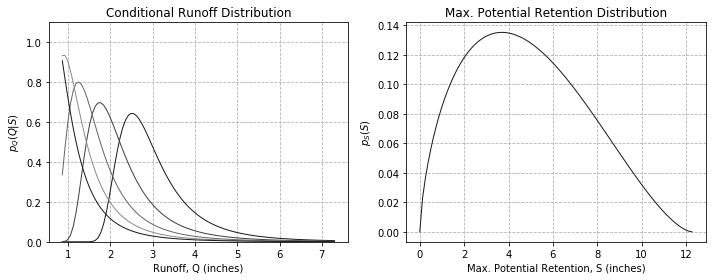

In [15]:
#Cycle though Color and line weights of graph
custom_cycler = cycler('color', ['.1', '.25', '.4', '.55']) + cycler('lw', [1, 1, 1, 1])

#Runoff x-axis values 
Q = np.linspace(PPF_GEV(10**-100, GEV_parameters_E, PMP), PPF_GEV(0.99, GEV_parameters_E, PMP), 100)

#Max. Potential Retention x-axis values
S = np.linspace(0, S_limit, 100)

fig, ((fig2a, fig2b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#Plot Figure 2a
fig2a.set_prop_cycle(custom_cycler)
SA=np.linspace(.1, 3.5 , 5)
fig2a.plot(Q, np.transpose([PDF_QlS(Q, S1, mu, GEV_parameters_E, PMP) for S1 in SA]))
fig2a.grid(linestyle='--')
fig2a.set_ylim((0, 1.1))
fig2a.set_xlabel('Runoff, Q (inches)'),fig2a.set_ylabel('$p_Q(Q | S)$'), fig2a.set_title('Conditional Runoff Distribution')

#Plot Figure 2b
fig2b.set_prop_cycle(custom_cycler)
SA=np.linspace(.1, 3.5 , 5)
fig2b.plot(S, (1/S_limit)*stats.beta(alpha, beta).pdf(S/S_limit))
fig2b.grid(linestyle='--')
#fig2b.set_ylim((0, 1.1))
fig2b.set_xlabel('Max. Potential Retention, S (inches)'),fig2b.set_ylabel('$p_S(S)$'), fig2b.set_title('Max. Potential Retention Distribution')

plt.tight_layout()
plt.show()

## Runoff as a function of the return period

In [16]:
#error between the integral approach (based on summation integration) and the actual value
error_PQ = 1- CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P)

#Print Results
print('\n'
      'Probability of zero runoff = %s \n' 
      'Error in calculation of Probabilibity of zero runoff = %s \n'
      'Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = %s'
      %(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[1], error_PQ ))

#Time the integration
#  %timeit CDF_Q( 3 , 0.2, alpha, beta, S_limit, GEV_parameters_E)


Probability of zero runoff = 0.0014810647057318107 
Error in calculation of Probabilibity of zero runoff = 1.7935516371868464e-09 
Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = -0.0002792544221246196


### Determine Runoff Values and Weights
- Runoff weights calculated starting from a given bin ceiling.

In [17]:
#tck_RI_Q, tck_Q_RI respectively are cubic spline interpolation functions for runoff as a function of return period and return period as a function of runoff, respectively.
tck_RI_Q, tck_Q_RI, df_weights_runoff = runoff(Return_Intervals, RI_upper_bound, mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
df_weights_runoff

Bin Ceiling = 3700.0, Bin Floor 2492.0196379995623
Bin Ceiling = 2492.0196379995623, Bin Floor 1647.9285320004499
Bin Ceiling = 1647.9285320004499, Bin Floor 681.580686071757
Bin Ceiling = 681.580686071757, Bin Floor 384.84951420872403
Bin Ceiling = 384.84951420872403, Bin Floor 124.89030540437155
Bin Ceiling = 124.89030540437155, Bin Floor 82.20618177000969
Bin Ceiling = 82.20618177000969, Bin Floor 34.15449730219781
Bin Ceiling = 34.15449730219781, Bin Floor 19.495268242956428
Bin Ceiling = 19.495268242956428, Bin Floor 6.412861597958584
Bin Ceiling = 6.412861597958584, Bin Floor 3.8852031564024654
Bin Ceiling = 3.8852031564024654, Bin Floor 1.276709424312079


,Bin Floor,Bin Celing,Event Weight,Runoff
2,1.276709,3.885203,0.525877,0.715605
5,3.885203,6.412862,0.101450,1.575553
10,6.412862,19.495268,0.104642,2.185044
25,19.495268,34.154497,0.022016,3.004274
50,34.154497,82.206182,0.017114,3.713956
100,82.206182,124.890305,0.004158,4.542055
200,124.890305,384.849514,0.005409,5.518922
500,384.849514,681.580686,0.001131,7.081325
1000,681.580686,1647.928532,0.000860,8.494071
2000,1647.928532,2492.019638,0.000206,10.112125


### Plot runoff distribution

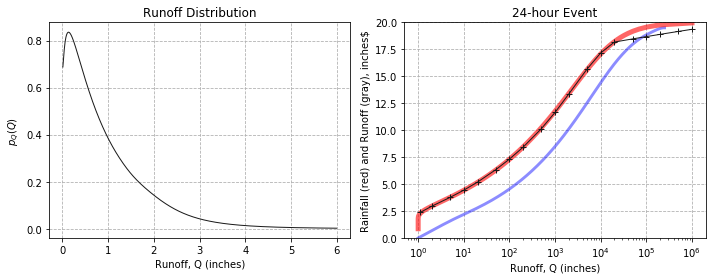

In [24]:
fig, ((fig3a, fig3b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

# x-axis value for the max. potential retention distribution
Q1= np.linspace(.01, 6, 1000)
Return_PeriodQ = np.linspace(1, 10**5.4, 100000)

#Plot Figure 3a
fig3a.set_prop_cycle(custom_cycler)
fig3a.plot(Q1,PDF_Q(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P))
fig3a.grid(linestyle='--')
#fig2b.set_ylim((0, 1.1))
fig3a.set_xlabel('Runoff, Q (inches)'),fig3a.set_ylabel('$p_Q(Q)$'), fig3a.set_title('Runoff Distribution')

#Plot Figure 3b
fig3b.set_xscale('log')
fig3b.set_prop_cycle(custom_cycler)
#Return Inteval vs Runoff
#fig3b.plot(Return_PeriodQ, Q_line, lw =5, alpha=.1)
#Plot Runoff vs Return interval based on the intepolation function
fig3b.plot(Return_PeriodQ, interpolate.splev(Return_PeriodQ, tck_RI_Q, der=0), 'b', lw =2.9, alpha=.45)
#Return Interval vs Rainfall (i.e., Precipitation)
fig3b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
#NOAA Atlas 14 values
mean_curve_precip['Expected Value'].plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, 18))
fig3b.grid(linestyle='--')
fig3b.set_ylim((0, PMP))
fig3b.set_xlabel('Runoff, Q (inches)'),fig3b.set_ylabel('Rainfall (red) and Runoff (gray), inches$'), fig3b.set_title('24-hour Event')

plt.tight_layout()
plt.show()

### Plot maximum potential distribution conditional on runoff

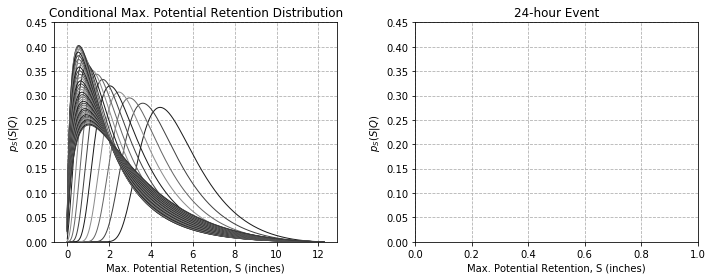

In [19]:
#Cycle though Color and line weights of graph
custom_cycler = cycler('color', ['.1', '.25', '.4', '.55']) + cycler('lw', [1, 1, 1, 1])

fig, ((fig4a, fig4b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

S1= np.linspace(.01, S_limit, 1000)
S2= np.linspace(.01, S_limit, 10)

#Plot Figure 4a
fig4a.set_prop_cycle(custom_cycler)
QA=np.linspace(.5, 10 , 50)
fig4a.plot(S1, np.transpose([PDF_SlQ(S1, Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit) for Q1 in QA]))
fig4a.grid(linestyle='--')
fig4a.set_ylim((0, .45))
fig4a.set_xlabel('Max. Potential Retention, S (inches)'),fig4a.set_ylabel('$p_S(S | Q)$'), fig4a.set_title('Conditional Max. Potential Retention Distribution')

#Plot Figure 4b
fig4b.set_prop_cycle(custom_cycler)
QA=np.linspace(2, 10 , 4)
#fig4b.plot(S2, np.transpose([CDF_SlQ(S2, Q1, mu, GEV_parameters_E, alpha, beta, S_limit) for Q1 in QA]))
fig4b.grid(linestyle='--')
fig4b.set_ylim((0, .45))
fig4b.set_xlabel('Max. Potential Retention, S (inches)'),fig4b.set_ylabel('$p_S(S | Q)$'), fig4b.set_title('24-hour Event')

plt.tight_layout()
plt.show()

### Calculate Runoff and Corresponding Max. Potential Retention and Rainfall

In [20]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit)
df_runoff_SR1

Calculating Median S for Runoff = 0.7156052302598954
Calculating Median S for Runoff = 1.5755530257358075
Calculating Median S for Runoff = 2.1850444249733463
Calculating Median S for Runoff = 3.004274396780283
Calculating Median S for Runoff = 3.713955721080635
Calculating Median S for Runoff = 4.542055496797915
Calculating Median S for Runoff = 5.518921544666174
Calculating Median S for Runoff = 7.081324796820836
Calculating Median S for Runoff = 8.494071098936635
Calculating Median S for Runoff = 10.112125268887688
Calculating Median S for Runoff = 11.144826279402853
Calculating Median S for Runoff = 14.174537119321556


,Bin Floor,Bin Celing,Event Weight,Runoff,Avg. S,Rainfall,Median S,Rainfall
2,1.276709,3.885203,0.525877,0.715605,4.554415,3.109116,4.225128,2.978088
5,3.885203,6.412862,0.101450,1.575553,2.762083,3.570081,2.311262,3.314516
10,6.412862,19.495268,0.104642,2.185044,2.154828,3.952891,1.709550,3.654578
25,19.495268,34.154497,0.022016,3.004274,2.048459,4.811923,1.484815,4.390858
50,34.154497,82.206182,0.017114,3.713956,2.140036,5.660835,1.549414,5.200476
100,82.206182,124.890305,0.004158,4.542055,2.279710,6.665515,1.688008,6.189773
200,124.890305,384.849514,0.005409,5.518922,2.438981,7.838027,1.854636,7.355340
500,384.849514,681.580686,0.001131,7.081325,2.658137,9.672238,2.092447,9.189217
1000,681.580686,1647.928532,0.000860,8.494071,2.821697,11.292502,2.271468,10.811266
2000,1647.928532,2492.019638,0.000206,10.112125,2.977964,13.113379,2.444241,12.635767


## Hydrology 3 Events
- For each runoff value, two events are considered, a high max. potential retention, and a low max. potential retention

In [21]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha,beta,S_limit)
df_runoff_SR2

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall,Event Weight,Runoff,Avg. S (Upper 50%),Rainfall
2,0.262938,0.715605,3.271858,2.583601,0.262938,0.715605,5.836972,3.600044
5,0.050725,1.575553,1.497513,2.813548,0.050725,1.575553,4.026653,4.232198
10,0.052321,2.185044,0.946711,3.088023,0.052321,2.185044,3.362946,4.687745
25,0.011008,3.004274,0.756969,3.782042,0.011008,3.004274,3.339948,5.675913
50,0.008557,3.713956,0.781312,4.533186,0.008557,3.713956,3.498760,6.611678
100,0.002079,4.542055,0.853006,5.446952,0.002079,4.542055,3.706414,7.701906
200,0.002704,5.518922,0.943119,6.528534,0.002704,5.518922,3.934843,8.962213
500,0.000566,7.081325,1.076545,8.245922,0.000566,7.081325,4.239729,10.912348
1000,0.000430,8.494071,1.179052,9.779285,0.000430,8.494071,4.464342,12.620395
2000,0.000103,10.112125,1.279681,11.517163,0.000103,10.112125,4.676246,14.526566


---